In [ ]:
## Семинар 10: "Чат-боты"

ФИО: Лыжов Александр

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import string
import unicodedata
import random
from os import listdir
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель Seq2Seq, обученную на субтитрах какого-нибудь фильма.

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb>реализация машинного перевода на PyTorch</a>

### Часть 1: подготовка данных

Скачайте субтитры вашего любимого фильма с сайта https://www.opensubtitles.org/en и поместите их в папку с ноутбуком, назвав файл subtitles.srt

### Чтение данных

In [2]:
def clean_line(line):
    line = line.strip().decode('utf-8')
    if '-->' in line or line.isalnum() or 'subtitles' in line:
        line = u''
    line = re.sub('<[^>]*>', '', line, flags=re.U)
    words = re.findall(r'\w*', line, flags=re.U)
    words = filter(lambda x: x.isalnum(), words)
    clean = u' '.join(words)
    if clean.isalnum():
        clean = u''
    clean = clean.lower()
    clean = re.sub(r"([.!?])", r" \1", clean, flags=re.U)
    clean = re.sub(r"[^a-zA-Z.!?]+", r" ", clean, flags=re.U)
    clean = clean.strip()
    return clean

In [3]:
lines = []
for filename in listdir('sub'):
    lines.extend(open('sub/' + filename).readlines())

In [4]:
len(lines)

79190

In [5]:
lines = map(clean_line, lines)
lines = filter(len, lines)
lines = filter(lambda line: len(line.split(' ')) <= 9, lines)

In [6]:
len(lines)

24996

In [7]:
for i in range(10):
    print lines[i]

steve i just got a weird e mail
did you buy us airline tickets
aw shoot it was supposed
to be a surprise
i wanted to thank you for letting
me live here all this time
so i m treating the family
to a vacation
steve you re so sweet
thanks uncle steve


### Построение словаря

In [8]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word2count[word] = 1
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [9]:
vocab = Lang()
for line in lines:
    vocab.addSentence(line)

In [10]:
def indexesFromSentence(vocab, sentence):
    return [vocab.word2index[word] for word in sentence.split(' ')]

def variableFromSentence(vocab, sentence):
    indexes = indexesFromSentence(vocab, sentence)
    indexes.append(EOS_token)
    return Variable(torch.LongTensor(indexes).view(-1, 1)).cuda()

def variablesFromPair(pair):
    input_variable = variableFromSentence(vocab, pair[0])
    target_variable = variableFromSentence(vocab, pair[1])
    return (input_variable, target_variable)

In [11]:
pairs = zip(lines[:-1], lines[1:])

In [12]:
pairs[50:65]

[(u'it s', u'it s disgusting'),
 (u'it s disgusting', u'steve wasn t real'),
 (u'steve wasn t real', u'he s a real piece of shit'),
 (u'he s a real piece of shit', u'this is a big one'),
 (u'this is a big one', u'somebody probably'),
 (u'somebody probably', u'tracked it in last week'),
 (u'tracked it in last week', u'on the bottom of their shoe on'),
 (u'on the bottom of their shoe on', u'a piece of alien fruit'),
 (u'a piece of alien fruit', u'get off the high road summer'),
 (u'get off the high road summer', u'we all got pink eye because you'),
 (u'we all got pink eye because you', u'won t stop texting on the toilet'),
 (u'won t stop texting on the toilet', u'but uncle steve taught me'),
 (u'but uncle steve taught me', u'how to ride a bike'),
 (u'how to ride a bike', u'no steve put that memory'),
 (u'no steve put that memory', u'in your brain')]

In [337]:
# variablesFromPair(vocab, pairs[2])

In [338]:
# pairs_backup = pairs[:]

In [339]:
# pairs = pairs[:50]

In [13]:
tensors = map(variablesFromPair, pairs)

In [14]:
MAX_LENGTH = int(max([tensor[0].size()[0] for tensor in tensors]))
print(MAX_LENGTH)

10


In [15]:
len(pairs)

24995

### Часть 2: определение модели

<i> 2.1 Реализуйте encoder </i>

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size).cuda()
        self.gru = nn.GRU(hidden_size, hidden_size).cuda()
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size)).cuda()

<i> 2.2 Реализуйте decoder </i>

<i> 2.3 Реализуйте forward </i>

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size).cuda()
        self.gru = nn.GRU(hidden_size, hidden_size).cuda()
        self.out = nn.Linear(hidden_size, output_size).cuda()
        self.softmax = nn.LogSoftmax().cuda()
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size)).cuda()

In [63]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size).cuda()
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length).cuda()
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size).cuda()
        self.dropout = nn.Dropout(self.dropout_p).cuda()
        self.gru = nn.GRU(self.hidden_size, self.hidden_size).cuda()
        self.out = nn.Linear(self.hidden_size, self.output_size).cuda()
        
    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size)).cuda()

### Часть 3: обучение модели

<i> 3.1 Обучите модель при помощи SGD </i>

In [53]:
teacher_forcing_ratio = 0.5

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size)).cuda()
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]])).cuda()
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            loss += criterion(decoder_output[0], target_variable[di])
            decoder_input = target_variable[di] # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoder_input = Variable(torch.LongTensor([[ni]])).cuda()
            loss += criterion(decoder_output[0], target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [54]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    if percent != 0:
        es = s / (percent)
    else:
        es = 0
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [55]:
def plot_losses(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [56]:
def trainEpochs(encoder, decoder, n_epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [random.choice(tensors) for i in range(n_epochs)]
    criterion = nn.NLLLoss()
    
    for epoch in range(1, n_epochs + 1):
        training_pair = training_pairs[epoch - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
        loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg))
        
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    return losses

In [59]:
hidden_size = 256 # set to 256

In [60]:
encoder = EncoderRNN(vocab.n_words, hidden_size)

In [61]:
decoder = AttnDecoderRNN(hidden_size, vocab.n_words, 1, dropout_p=0.1)

In [48]:
losses = trainEpochs(encoder, decoder, 150000, print_every = 3000, plot_every=3000) # 75000 epochs?

3m 39s (- -4m 20s) (3000 0%) 4.8078
7m 22s (- -8m 37s) (6000 0%) 4.6991
11m 7s (- -12m 52s) (9000 0%) 4.5920
14m 51s (- -15m 8s) (12000 0%) 4.5163
18m 37s (- -19m 22s) (15000 0%) 4.4919
22m 22s (- -23m 37s) (18000 0%) 4.4164
26m 9s (- -27m 50s) (21000 0%) 4.3905
29m 53s (- -30m 6s) (24000 0%) 4.2994
33m 42s (- -34m 17s) (27000 0%) 4.3254
37m 29s (- -38m 30s) (30000 0%) 4.2971
41m 15s (- -42m 44s) (33000 0%) 4.2118
45m 3s (- -46m 56s) (36000 0%) 4.1706
48m 54s (- -49m 5s) (39000 0%) 4.1460
52m 41s (- -53m 18s) (42000 0%) 4.1043
56m 30s (- -57m 29s) (45000 0%) 4.0779
60m 19s (- -61m 40s) (48000 0%) 4.0487
64m 7s (- -65m 52s) (51000 0%) 3.9795
67m 58s (- -68m 1s) (54000 0%) 3.9945
71m 48s (- -72m 11s) (57000 0%) 3.8785
75m 40s (- -76m 19s) (60000 0%) 3.8894
79m 32s (- -80m 27s) (63000 0%) 3.8233
83m 23s (- -84m 36s) (66000 0%) 3.7896
87m 15s (- -88m 44s) (69000 0%) 3.7683
91m 9s (- -92m 50s) (72000 0%) 3.6963
95m 3s (- -96m 56s) (75000 0%) 3.7032
98m 55s (- -99m 4s) (78000 0%) 3.6214
102m

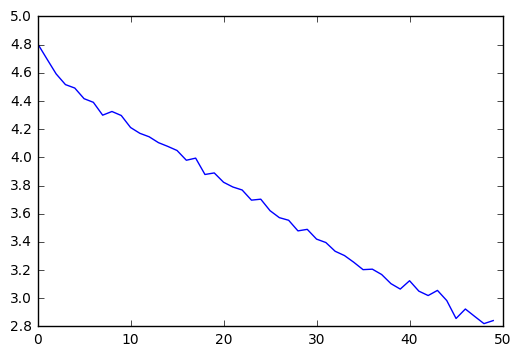

In [49]:
plot_losses(losses)

In [51]:
# torch.save(encoder.state_dict(), 'encoder_dict')

In [52]:
# torch.save(decoder.state_dict(), 'decoder_dict')

In [21]:
encoder.load_state_dict(torch.load('encoder_dict'))

In [22]:
decoder.load_state_dict(torch.load('decoder_dict'))

<i> 2.4 Реализуйте evaluate (на каждой итерации выбирайте наиболее вероятное слово)</i>

### Часть 4: оценивание модели

<i> 4.1 Продемонстрируйте ответы модели на различные предложения </i>

In [23]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(vocab, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size)).cuda()
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]])).cuda() # SOS
    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden,
                                                                    encoder_output, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(vocab.index2word[ni])
        decoder_input = Variable(torch.LongTensor([[ni]])).cuda()
    
    return decoded_words, decoder_attentions[:di+1]

In [24]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [53]:
evaluateRandomly(encoder, decoder)

('>', u'we gotta be careful')
('=', u'i lost the chance')
('<', u'i lost the <EOS>')

('>', u'a very satisfying project for')
('=', u'people of all ages')
('<', u'people of all ages <EOS>')

('>', u'be less powerful')
('=', u'never gonna happen though')
('<', u'and i <EOS>')

('>', u'out of the way morty')
('=', u'morty that s one of')
('<', u'you hey the the <EOS>')

('>', u'morty jr smoking')
('=', u'that is not okay')
('<', u'that is a <EOS>')

('>', u'infinite time lines')
('=', u'we re not on any')
('<', u'through me <EOS>')

('>', u'plan your route accordingly')
('=', u'and expect delays')
('<', u'and re re <EOS>')

('>', u'how this place works')
('=', u'is there any way we could')
('<', u'there is there any way we could <EOS>')

('>', u'we were dead')
('=', u'so we came here and')
('<', u'no i <EOS>')

('>', u'fresh start morty')
('=', u'create a whole fresh start')
('<', u'a whole a whole <EOS>')



In [28]:
evaluate(encoder, decoder, 'hey morty')[0]

[u'hey', u'you', u'know', '<EOS>']

In [34]:
evaluate(encoder, decoder, 'there s more')[0]

[u'there', u'are', u'are', u'coming', u'and', u'they', '<EOS>']

In [38]:
evaluate(encoder, decoder, 'time s up')[0]

[u'i', u'm', u'taming', u'the', u'council', '<EOS>']